In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm
#import sklearn.linear_model

import arviz as az
import pymc3 as pm
#import plotly.express as px

# Assignment 1: Toxicity bioassay

## Problem and data

A **bioassay** is biochemical test to estimate the potency of a sample compound. A typical bioassay involves a stimulus (ex. drugs) applied to a subject (ex. animals, tissues, plants). The corresponding response (ex. death) of the subject is thereby triggered and measured (Wikipedia).

The following bioassay taken from Racine et al. (1986) is meant to evaluate the toxicity of a drug on animals. The effect of the drug is evaluated at $k=5$ dose levels. Each dose level $x_i$ is administered to a batch of $n_i$ animals. The number of deaths $y_i$ is the observed response.

| |Dose $x_i$ (log g/ml) | Number of animals $n_i$ | Number of deaths $y_i$ |
| ---|--- | --- | --- |
| 1|-0.86 | 5 | 0 |
| 2|-0.30 | 5 | 1 |
| 3|-0.05 | 5 | 3 |
| 4|0.73  | 5 | 5 |


For instance, the dose level $x_3=-0.05$ has been administered at $n_3=5$ animals. Out of the 5 animals, $y_3=3$ died. <br/>
Note that the dose $x_i$ is measured on a logarithmic scales. Thus, negative concentration levels are present.

In [2]:
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5., 5., 5., 5.])
y = np.array([0, 1, 3, 5])

## Modeling assumptions

For the probabilistic model, we make the following assumptions:

1. The outcome of the $n_i$ animals within each group $i$ are *independent*. Each animal in the group has probability $p_i$
   of death. Consequently, the outcomes $y_i$ are binomially distributed:
   $$y_i | p_i \sim  \mathrm{Binomial}(n_i, p_i)$$
2. The probability of death $p_i$ depends on the dose $x_i$ as follows:
    $$p_i = \rm{sigm}(\alpha + \beta x_i),$$ 
    where 
    \begin{align*}
    \rm{sigm}(z) = \frac{1}{1 + e^{-z}}.
    \end{align*}
3. The prior probability of the parameters 
$\theta = \begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}$
is normal, with mean
$\mu_0 = \begin{bmatrix}
0 \\
10
\end{bmatrix}$ and covariance 
$
\Sigma_0 = \begin{bmatrix}
4 & 12 \\
12 & 100
\end{bmatrix},
$

## 1.1: Probabilistic model

* Derive and comment the full probabilistic model. (Add a diagram?)

Putting together the probabilistic assumptions 1-3, we obtain:

\begin{align*}
y_i | p_i &\sim  \mathrm{Binomial}(n_i, \rm{sigm}(\alpha + \beta x_i))\\
%p_i &= \rm{sigm}(\alpha + \beta x_i) \\
\theta = 
\begin{bmatrix}
\alpha \\
\beta
\end{bmatrix} &\sim \mathcal{N}(\mu_0, \Sigma_0), \qquad 
\mu_0 = \begin{bmatrix}
0 \\
10
\end{bmatrix}, \;\;
\Sigma_0 = \begin{bmatrix}
4 & 12 \\
12 & 100
\end{bmatrix}
\end{align*}

## 1.2: Maximum Likelihood estimation 

* Obtain a mathematical expression of the likelihood function $\mathcal{L}(\theta)$.

The likelihood function $\mathcal{L}(\theta)$ is $p(y|\theta)$, seen as a function of $\theta$, with $y$ fixed to the observed outcome. <br/>Since the individual observations $y_i$ are independent, we have:

$$\mathcal{L}(\theta) = p(y|\theta) = \prod_i {{n_i}\choose{y_i}} \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot (1- \mathrm{sigm}(\alpha + \beta x_i))^{n_i - y_i}$$

* Write a python function corresponding to the likelihood function $\mathcal{L}(\theta)$ (up to multiplicative factors)

In [3]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def lik(alpha, beta):
    pass
    # ... TODO

In [4]:
# Likelihood of the 4 observations (neglecting the multiplicative factor).
# The overall likelihood is the product of all terms.

def lik(alpha, beta):
    gamma = sigmoid(alpha+beta*x)
    lik = gamma**y * (1-gamma)**(n-y)
    return np.prod(lik, axis=-1)

* Visualize the likelihood function in 2D and comment the obtained figure. 
Hints:
    * you may use the `pcolormesh` function of matplotlib
    * appropriate ranges for $\alpha$ and $\beta$ are $[-4, 8]$ and $[-10, 40]$, respectively 

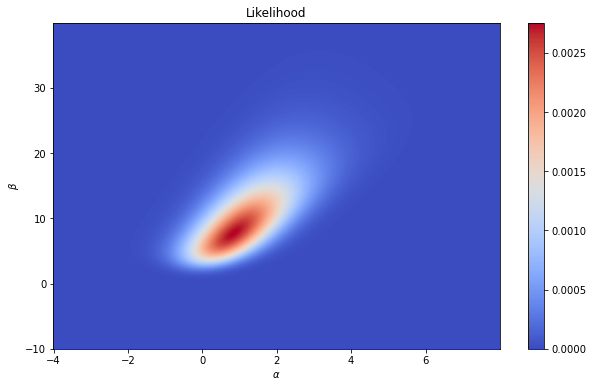

In [5]:
dalpha = 0.01
dbeta = 0.01
ALPHA = np.arange(-4, 8, dalpha)
BETA = np.arange(-10, 40, dbeta)
AA, BB = np.meshgrid(ALPHA, BETA, indexing='xy')
AABB = np.stack((AA, BB), axis=-1)
LL = lik(AA[..., np.newaxis], BB[..., np.newaxis])

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, LL, cmap=cm.coolwarm, shading='auto')
#plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

Parameters $\alpha$ and $\beta$ are positively correlated, the maximum likelihood estimate is around (1, 8), the numerical scale is small (0 ... 0.0025).

* Obtain an analytical expression of the log-likelihood function $\ell(\theta)$. 

In [ ]:
In this case, the likelihood is numerically well-posed (not too many samples, not too many multiplications). The scale 0-0.05 is not too bad! In general, it is better to work with logarithms. Let us compute the *log-likelihood* $\ell(\theta)$:

$$\ell(\theta) = \log \mathcal{L}(\theta) = \sum_i {{n_i}\choose{y_i}} + \sum_i y_i \log \mathrm{sigm}(\alpha + \beta x_i) +  (n_i - y_i) \log (1- \mathrm{sigm}(\alpha + \beta x_i)).$$

The constant term $\sum_i {{n_i}\choose{y_i}}$ may be ignored.

* Write a python function corresponding to the log-likelihood function $\ell(\theta)$ (possibly up to an additive factor) and comment the obtained figure

In [6]:
def log_lik(alpha, beta):
    gamma = sigmoid(alpha+beta*x)
    #log_lik = y*np.log(gamma) + (n-y)*np.log(1-gamma)
    # nan_to_num handles the multiplication 0*np.inf and set it to 0, as required in our case...
    log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)
    return np.sum(log_lik, axis=-1)

/tmp/ipykernel_10217/1299308094.py:5: RuntimeWarning: divide by zero encountered in log
  log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)
/tmp/ipykernel_10217/1299308094.py:5: RuntimeWarning: invalid value encountered in multiply
  log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)


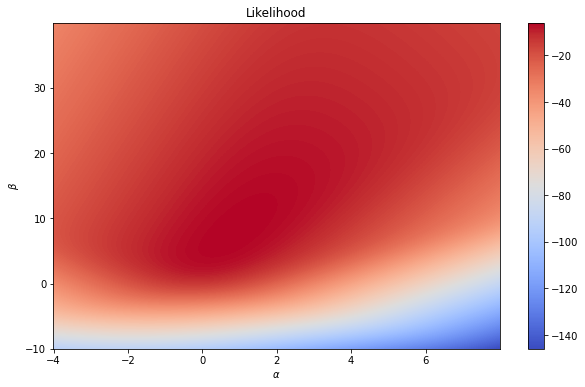

In [7]:
LOG_LL = log_lik(AA[..., np.newaxis], BB[..., np.newaxis])
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, LOG_LL, cmap=cm.coolwarm, shading='auto')
#plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

* Obtain the maximum likelihood estimate of the parameters $\alpha^{\rm ml}, \beta^{\rm ml}$ of the parameters $\alpha, \beta$ through numerical optimizations. Hints:
    * You may use the function `scipy.optimize.minimize`. 
    * You may look at the figures above to define a good starting point for optimization 
    * You may either minimize the likelihood or the log-likelihood. What is your choice?

In [8]:
from scipy.optimize import minimize

log_lik_theta = lambda theta: log_lik(theta[0], theta[1])
nll_theta = lambda theta: -log_lik_theta(theta) # negative log-likelihood function.
res = minimize(nll_theta, x0=[1, 8])
theta_ml = res.x

* Plot the maximum likelihood estimate together with the likelihood function. Comment the obtained results

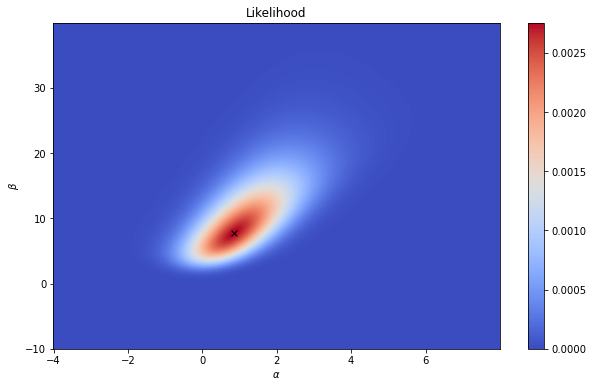

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, LL, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

## 1.2: Maximum A Posteriori Estimation

* Find an analytical expression of the posterior $p(\theta | y)$, up to a multiplicative factor not depending on $\theta$. Hint: exploit the already-obtained likelihood.

$$p(\theta | y) = \frac{p(y | \theta) p(\theta)}{p(y)} \propto \mathcal{L}(\theta) \exp\left(-\frac{1}{2} 
(\theta - \mu)^{\top} \Sigma_0^{-1} (\theta - \mu)^{\top} \right).$$

* Find an analytical expression of the log-posterior $\log p(\theta | y)$, up to an additive factor not depending on $\theta$.

$$\log p(\theta | y) = \log \frac{p(y | \theta) p(\theta)}{p(y)} = \log p(y | \theta) + \log p(\theta) - \log p(y) = \ell(\theta) - \frac{1}{2} (\theta - \mu)^{\top} \Sigma_0^{-1} (\theta - \mu)^{\top} + \rm{cnst}.$$

* Obtain the unnormalized posterior and the log-posterior as python functions

In [10]:
mu = np.array([0, 10])
cov_0 = np.array([[4, 12], [12, 100]]) 
prior_fun = stats.multivariate_normal(mean=mu, cov=cov_0)

p_post_unscaled = lambda theta: lik_theta(theta)*prior_fun.pdf(theta)
log_p_post_unscaled = lambda theta: log_lik_theta(theta) + prior_fun.logpdf(theta)

* Find the maximum a posteriore estimate $\alpha^{\rm map}, \beta^{\rm map}$

In [11]:
minus_logpost = lambda theta: -log_p_post_unscaled(theta)
res = minimize(minus_logpost, x0=[0, 10])
theta_map = res.x

* Visualize the MAP estimate together with the unnormalized posterior. Comment the results.

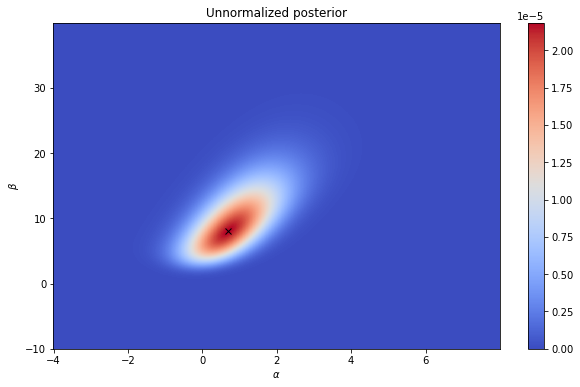

In [12]:
PP = prior_fun.pdf(AABB) # Prior
POST_UNSC = LL * PP

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, POST_UNSC, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_map[0], theta_map[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Unnormalized posterior");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

## 1.3 Brute-force posterior estimation

* Starting from the unnormalized posterior obtained in the previous section, obtain an approximation of the posterior (with the right normalization constant)

We have:
    $$ \tilde p(\theta | y) = \mathcal{L}(\theta) \exp\left(-\frac{1}{2} 
(\theta - \mu)^{\top} \Sigma_0^{-1} (\theta - \mu)^{\top} \right) = Z p(\theta | y),$$
where $Z$ is the to-be-determined normalization constant and it must be chosen such that:
$$\iint p(\theta | y) d\alpha\; d\beta = 1.$$
Thus,
$$Z = \iint p(\theta | y) d\alpha\; d\beta.$$

The integral above is intractable, but a gridding approximation may be used. Using an equi-spaced gridding, a Riemann Sum approximation is:

$$Z \approx \Delta \alpha \Delta \beta \sum_i p(\theta_i | y),$$

where $\Delta \alpha$ and $\Delta \beta$ are the discretization steps of the 2D grid and $\theta_i$ are the grid points.

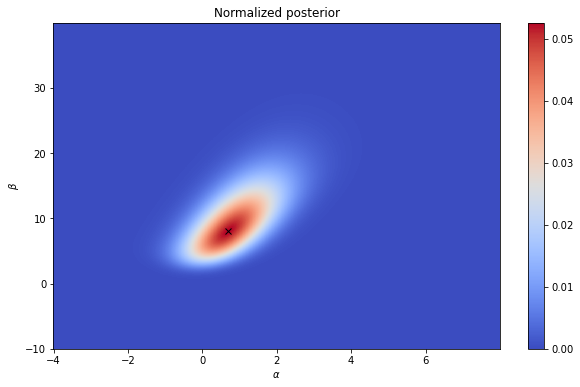

In [13]:
dalpha = 0.01
dbeta = 0.01
normalizing_factor = np.sum(POST_UNSC)*dalpha*dbeta
POST_SC = POST_UNSC/normalizing_factor


fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, POST_SC, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_map[0], theta_map[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Normalized posterior");
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");

* Using the grid-based approximation of the posterior, compute the posterior mean of $\alpha$ and $\beta$.

By definition, we have:

$$E[\theta] = \iint \theta p(\theta | y) d\alpha\; d\beta.$$

Using the grid-based approximation above:

$$E[\theta] = \Delta \alpha \Delta \beta \sum \theta_i p(\theta_i | y).$$

Software implementation below

In [14]:
a_mean = np.sum(AA*POST_SC)*dalpha*dbeta
b_mean = np.sum(BB*POST_SC)*dalpha*dbeta
a_mean, b_mean

(0.9689882379839512, 10.59065917185099)

This is (yet another!) meaningful point estimate of $\theta$. 

## 1.4 Monte-carlo estimation

In [15]:
def log_post_fun(alpha, beta):
    return log_lik(alpha, beta) + prior_fun.logpdf([alpha, beta])

In [16]:
def p_ratio_fun(alpha_propose, beta_propose, alpha_previous, beta_previous):
    log_p_previous = log_post_fun(alpha_previous, beta_previous)
    log_p_propose = log_post_fun(alpha_propose, beta_propose)
    log_p_ratio = log_p_propose - log_p_previous # log(p_prop/p_prev) = log(p_prop) - log(p_prev)
    p_ratio = np.exp(log_p_ratio)
    return p_ratio

In [17]:
p_ratio_fun(alpha_propose = 1.89, alpha_previous = 0.374, beta_propose = 24.76, beta_previous = 20.04)

1.3051790385127726

In [18]:
p_ratio_fun(alpha_propose = 0.374, alpha_previous = 1.89, beta_propose = 20.04, beta_previous = 24.76)

0.7661784096222397

Let us run a Metropolis algorithm to sample from the posterior. The p_ratio function is all we need!

In [19]:
theta_0 = np.array([0, 10])
sigma = np.diag([1.0, 5.0])
theta_step = theta_0
N = 100_000
thetas = []

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma @ np.random.randn(2)
    #theta_prop = np.clip(theta_prop, 0, 1)
    
    p_ratio = p_ratio_fun(theta_prop[0], theta_prop[1], theta_step[0], theta_step[1])
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_step = theta_prop
thetas = np.stack(thetas)

/tmp/ipykernel_10217/1299308094.py:5: RuntimeWarning: divide by zero encountered in log
  log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)
/tmp/ipykernel_10217/1299308094.py:5: RuntimeWarning: invalid value encountered in multiply
  log_lik = np.nan_to_num(y*np.log(gamma), nan=0) + np.nan_to_num((n-y)*np.log(1-gamma), nan=0)


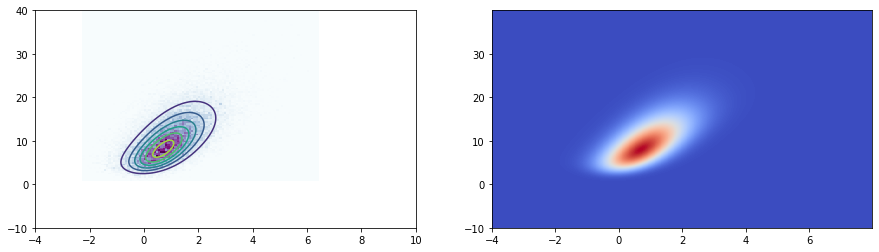

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist2d(x=thetas[:, 0], y=thetas[:, 1], bins=100, cmap=plt.cm.BuPu)
ax[0].set_xlim([-4, 10]);
ax[0].set_ylim([-10, 40]);
ax[0].contour(AA, BB, POST_SC); #, levels=[5, 15,  95]); # levels=[5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
c = ax[1].pcolormesh(AA, BB, POST_SC, cmap=cm.coolwarm, shading='auto')

In [21]:
np.mean(thetas[10_000:, :], axis=0)

array([ 0.95520775, 10.51575677])

In [22]:
np.cov(thetas.transpose())

array([[ 0.8067784 ,  2.50555808],
       [ 2.50555808, 21.3465238 ]])

In [23]:
np.sum(AA*POST_SC)*dalpha*dbeta, np.sum(BB*POST_SC)*dalpha*dbeta

(0.9689882379839512, 10.59065917185099)

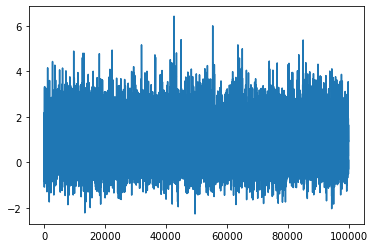

In [24]:
plt.plot(thetas[:,0])#px.scatter(thetas[:, 0])

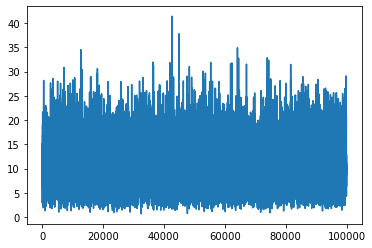

In [25]:
plt.plot(thetas[:, 1])

Let us do the sampling with pymc3

In [26]:
with pm.Model():
    theta = pm.MvNormal("theta", mu=mu, cov=cov_0, shape=(2,))
    p = pm.Deterministic("p", pm.math.sigmoid(theta[0] + theta[1]*x))
    y_var = pm.Binomial("y_var", n=n, p=p, observed=y)
    trace=pm.sample(10_000)

/tmp/ipykernel_10217/18138844.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


In [27]:
az.summary(trace)

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.952,0.919,-0.702,2.723,0.011,0.008,6663.0,8189.0,1.0
theta[1],10.507,4.670,2.875,19.140,0.062,0.045,5952.0,7420.0,1.0
p[0],0.007,0.022,0.000,0.030,0.000,0.000,6788.0,8144.0,1.0
p[1],0.138,0.107,0.001,0.336,0.001,0.001,11408.0,10090.0,1.0
p[2],0.591,0.168,0.288,0.897,0.002,0.001,8209.0,8744.0,1.0
p[3],0.991,0.028,0.960,1.000,0.000,0.000,5547.0,7548.0,1.0


/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

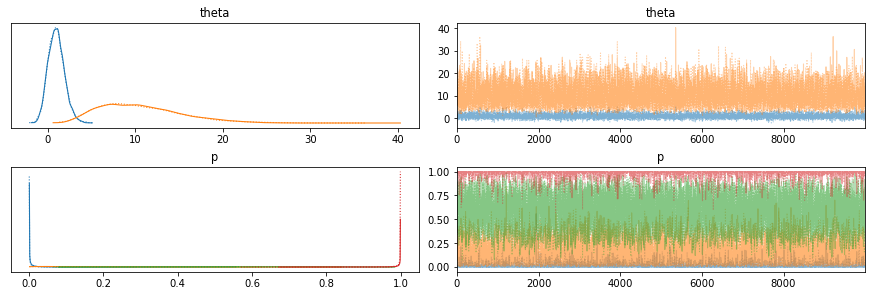

In [28]:
az.plot_trace(trace)

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'p\n0'}>],
       [<AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n2'}>,
        <AxesSubplot:title={'center':'p\n3'}>]], dtype=object)

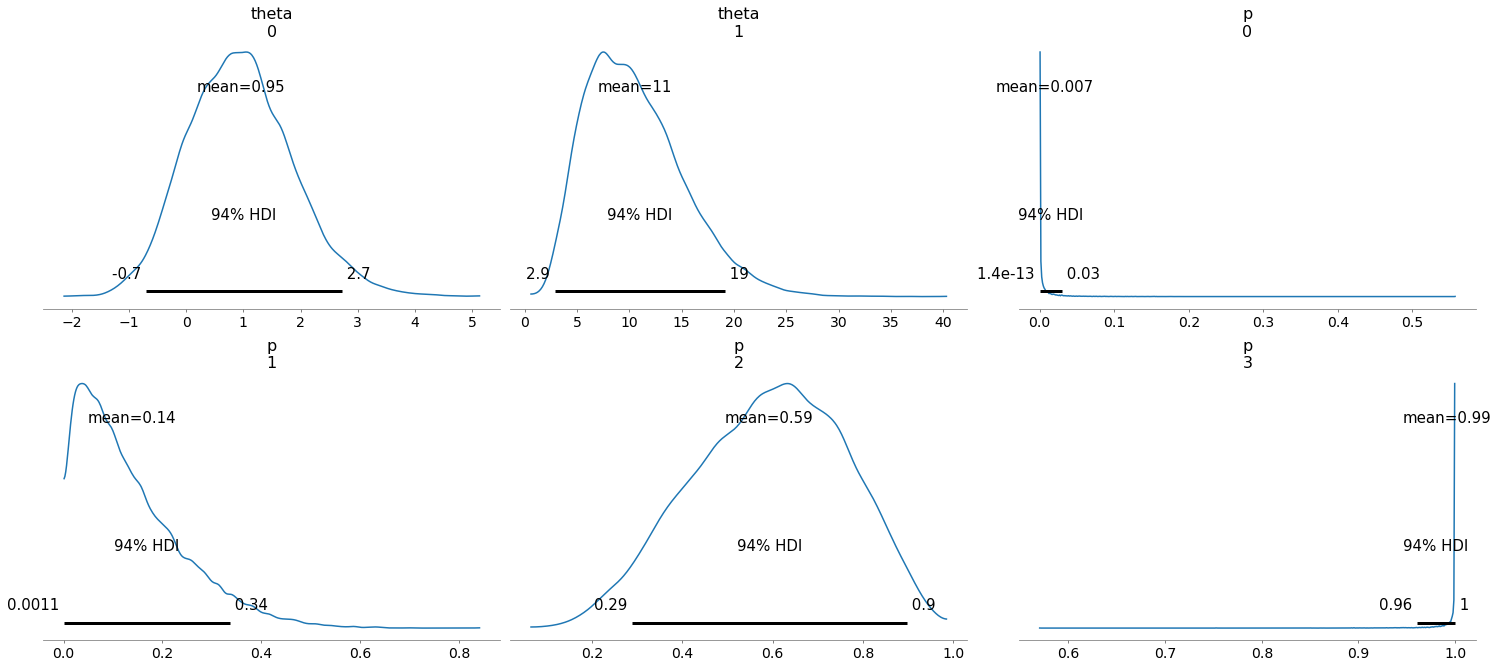

In [29]:
az.plot_posterior(trace)

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:xlabel='theta\n0', ylabel='theta\n1'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

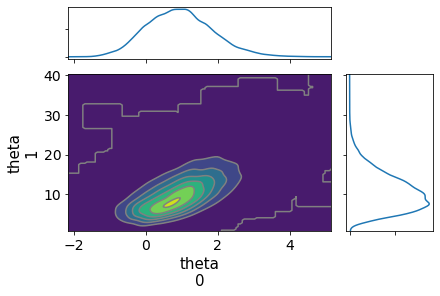

In [30]:
az.plot_joint(trace, var_names="theta", kind="kde")
